# EDA/Preprocessing ADFA-LD Dataset

**Description of Australian Defence Force Academy-Linux Dataset (ADFA-LD) :**

- 1) The dataset was generated on Linux local server running on Ubuntu 11.04, offering a variety
of functions such as file sharing, database, remote access and web server.
- 2) Six types of attacks occur in ADFA-LD including two brute force password guessing
attempts on the open ports enabled by FTP and SSH respectively, an unauthorised attempt to
create a new user with root privileges through encoding a malicious payload into a normal
executable, the uploads of Java and Linux executable Meterpreter payloads for the remote
compromise of a target host, and the compromise and privilege escalation using C100
webshell. These types are termed as Hydra-FTP, Hydra-SSH, Adduser, Java-Meterpreter,
Meterpreter and Webshell respectively. You can find these attacks inside the folder
“Attack_Data_Master”
- 3) 833 and 4373 normal traces are generated for training and validation respectively, over a
period during which no attacks occur against the host and legitimate application activities
ranging from web browsing to document writing are operated as usual. These training and
validation can be found in the “Training_Data_Master” and “Validation_Data_Master”
folders, respectively.


**Preprocessing Steps:**
- 1) Split the Attack data of each category (Hydra-FTP, Hydra-SSH, Adduser, Java-Meterpreter,
Meterpreter and Webshell ) into 70% training data and 30 % test data. For instance there are
are 10 folders in “Adduser” attack. Therefore, 7 of these folders are to be used for training
and 3 folders are to be used for testing.
 - 2) For the Normal data, files in “Training_Data_Master” folder are to be used as training data
and files in “Validation_Data_Master” folder are to be used as test data.
 - 3) Write a python script to find the frequency of occurences of all unique 3-grams, 5-grams
and 7-grams system call sequences in the training data for both Attack data (across all
categories of attack) and Normal data. For e.g., consider the following trace file
corresponding to the Adduser attack.
265 168 168 265 168 168 168 265 168 265 168 168 . . .
Your script to list all 3-grams should produce the following output:
265 168 168 -->3
168 168 265 -->2
168 265 168 -->3
168 168 168 -->1
265 168 265 -->1
NOTE: To save time you can concatenate your entire training file for a particular class of
attack and then run your script on the concatenated file instead of running it individually on
each file.
- 4) Perform the same task on files in the “Training_Data_Master” to obtain all the unique 3-
grams, 5-grams and 7-grams.
- 5) Once you have obtained the frequencies of all the unique n-grams terms in the training data,
use the top 30% n-grams terms with the highest frequency to create a data set. For instance
consider following results for Adduser data (1st File):
('240', '102', '221') 7
('204', '203', '5') 2
('195', '199', '60') 1
('5', '197', '45') 1
('5', '195', '5') 12
('6', '220', '4') 1
('191', '5', '133') 9
('13', '45', '5') 2
('60', '5', '197') 4
('3', '142', '7') 2
Hydra-FTP data (2nd File):
('3', '142', '7') 11
('219', '311', '240') 4
('240', '13', '240') 1
('33', '168', '146') 2
('6', '168', '102') 3
('5', '197', '45') 1
('5', '195', '5') 2
('3', '91', '5') 8
('42', '120', '197') 1
('174', '54', '5') 2
('6', '63', '6') 18
 Normal training data (3rd File):
 ('195', '10', '41') 1
('3', '142', '7') 3
('91', '240', '196') 2
('5', '195', '5') 2
('3', '102', '7') 17
('3', '195', '195') 14
('4', '78', '240') 1
('33', '195', '192') 2
('5', '197', '45') 15
('199', '45', '192') 1

 The top 30 % 3-grams terms with highest frequencies in Adduser, Hydra-FTP and Normal
data are [('5', '195', '5'), ('191', '5', '133'), ('240', '102', '221')], [('6', '63', '6'), ('3', '142', '7'), ('3', '91',
'5')] and [('3', '102', '7'), ('5', '197', '45'), ('3', '195', '195')], respectively. Designate ('5', '195', '5') as
feature 1(F1), ('191', '5', '133') as feature 2 (F2) ..... and ('3', '195', '195') as F9. Then, the generated
dataset should have 9 features and one class label ( Adduser, Hydra-FTP, Normal ) with each feature
corresponding to frequency of occurences of one of these 9 features. For instance for the 1st File,
the generated data should be
Freq of F1, Freq of F2, ...., Freq of F9 ----->12, 9, 7, 0, 2, 0, 0,1,0, Adduser
Freq of F1, Freq of F2, ...., Freq of F9 ----->2, 0, 0, 0, 3, 0, 17,15,14, Normal
This will be the final training data which will be used to train various classifiers.
- 6) Apply the same procedure to generate the test dataset from the test files of the attack data
(for all attack types) and the normal files in the “Validation_Data_Master” using the top
30% 3-grams terms with highest frequencies obtained during the training phase. The
classifier model developed during the training phase will finally be validated on the Test
dataset.


In [27]:
# LIBRARIES REQUIRED
import os, errno, csv
from collections import Counter
from datetime import datetime, timedelta
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

# FUNCTION DEFINITIONS
def calculate_7Grams(data,dictionary):
	'''
	This function will generate 7 grams from the data and store them in the dictionary.
	It will return the last 7-gram for calcuting the residuals of the 5-grams and 3-grams
	'''
	ngrams = ()
	for it in range(0, len(data) - 6):
		ngrams = tuple(data[it: (it + 7)])
		dictionary.setdefault(ngrams,0)
		dictionary[ngrams] += 1

	return ngrams

def calcualte_Grams(dict7, dict5, dict3):
	'''
	This function will calculate the proper 5-grams from the dictionary dict7 and store them in dictionary dict5
	and calculate the proper 3-grams from the dictionary dict5 and store them in dictionary dict3
	according to the main algo described in the latex document.
	'''
	# calcualting & storing the rest of 5-grams from the 7-grams
	grams5 = ()
	for key in dict7:
		grams5 = key[:5]
		dict5.setdefault(grams5,0)
		dict5[grams5] += dict7[key]
	
	# calcualting & storing the rest of 3-grams from the 5-grams
	grams3 = ()
	for key in dict5:
		grams3 = key[:3]
		dict3.setdefault(grams3,0)
		dict3[grams3] += dict5[key]

def calculateResidual(grams7, dict5, dict3):
	'''
	This function will take the last 7-gram as one of the attribute and calculate the corresponding residual 5-grams.
	Similarly, it will also calcualate the residual 3-grams from the last 5-gram
	'''
	# calculating the last two 5 grams from the last 7 gram
	residual5a = grams7[2:7]
	residual5b = grams7[1:6]
	dict5.setdefault(residual5a,0)
	dict5.setdefault(residual5b,0)
	dict5[residual5a] += 1
	dict5[residual5b] += 1
	
	# now calculating the residual 3-grams from the last 5-grams
	residual3a = residual5b[2:5]
	residual3b = residual5b[1:4]
	dict3.setdefault(residual3a,0)
	dict3.setdefault(residual3b,0)
	dict3[residual3a] += 1
	dict3[residual3b] += 1

def getFeatures(dict, path):
	'''
	This function will take a dictionary as input, get the top 30% of that dictionary and store them in the path file
	'''
	# get the top 30% of the data 
	dictTop30 = dict.most_common(int(0.3*len(dict)))
	# writing the top 30% tupples to the file
	writeFile(path, dictTop30)
	# return the top 30%
	return dictTop30

def getData(file):
	'''
	The function would open the file passed as the argument and then read the data
	as string. It would return this data after splitting.
	'''
	data = ""
	# reading the data of the file and storing in the variable "data"
	try:
		with open(file) as f:
			data = data  + f.read()
	except IOError as exc:
		if exc.errno != errno.EISDIR:
			raise

	# split data along the spaces
	data = data.split()
	return data

def remFile(file):	
	if os.path.isfile(file):
		os.remove(file)

def writeFile(file,data):
	'''
	This function will write the data to the file.
	'''
	remFile(file)
	filewrite=open(file,'a')
	for tmp in data:
		filewrite.write(str(tmp)+"\n")
	
	filewrite.close()

def validateGeneral_Auxillary(Features, Dictionary, Filewrite):
	for feature in Features:
		if feature[0] in Dictionary:
			Filewrite.write( (str(Dictionary[feature[0]]) + ',').rstrip('\n'))
		else:
			Filewrite.write( '0,'.rstrip('\n'))
	
def validateGenerate():
	'''
	It will generate the frequency counts for all the files of the Validation Dataset for all the 3/5/7-tupples
	'''
	print("\nFinding the frequency of features in the Validation Dataset.")
	files = glob('ADFA-LD/Validation_Data_Master/*.txt')

	remFile("VALIDATE/7.txt")
	remFile("VALIDATE/5.txt")
	remFile("VALIDATE/3.txt")

	filewrite7=open("VALIDATE/7.txt",'a')
	filewrite5=open("VALIDATE/5.txt",'a')
	filewrite3=open("VALIDATE/3.txt",'a')

	for i,file in enumerate(files):
		dict3 = {}
		dict5 = {}
		dict7 = {}

		# Get the data of the current file
		data = getData(file)

		# calcualting the 7 grams
		grams7 = calculate_7Grams(data, dict7)

		# calculating the residual
		calculateResidual(grams7, dict5, dict3)

		# Calculating 3-grams and 5-grams
		calcualte_Grams(dict7, dict5, dict3)

		# calculating the frequency for attack features
		validateGeneral_Auxillary(Features7, dict7, filewrite7)
		validateGeneral_Auxillary(Features5, dict5, filewrite5)
		validateGeneral_Auxillary(Features3, dict3, filewrite3)

		filewrite3.write('\n')
		filewrite5.write('\n')
		filewrite7.write('\n')

	filewrite7.close()	
	filewrite5.close()	
	filewrite3.close()	

	# For the Validation 30% of the Attack Dataset

	for AttackIterator,Attack in enumerate(AttackList):
		# For each folder(8-10) of the Attack
		remFile("VALIDATE/" + Attack +"7.txt")
		remFile("VALIDATE/" + Attack +"5.txt")
		remFile("VALIDATE/" + Attack +"3.txt")
		
		filewrite7=open("VALIDATE/" + Attack +"7.txt",'a')
		filewrite5=open("VALIDATE/" + Attack +"5.txt",'a')
		filewrite3=open("VALIDATE/" + Attack +"3.txt",'a')

		for foldernum in range(8,11):
			# path of the folder
			path = 'ADFA-LD/Attack_Data_Master/' + Attack + '_' + str(foldernum) + '/*.txt'
			# all the files in this folder
			files = glob(path)
			# for each file in this folder
			for file in files:
				# the following dictionaries will store the corresponding n-grams of the current file
				dict7 = {}
				dict5 = {}
				dict3 = {}

				# reading the data of the file and storing in the variable "attackdata"
				attackdata = getData(file)			

				# finding and storing the 7 grams of 'attackdata' in the dictionary 'dict7'
				grams7 = calculate_7Grams(attackdata, dict7)
				
				# according to the logic we need to calculate the last(residual) 5/3 grams separately
				calculateResidual(grams7, dict5, dict3)
				
				# calcualting & storing the rest of 5-grams from the 7-grams and 3-grams from the 5-grams
				calcualte_Grams(dict7, dict5, dict3)

				# calculating the frequency for attack features
				validateGeneral_Auxillary(Features7, dict7, filewrite7)
				validateGeneral_Auxillary(Features5, dict5, filewrite5)
				validateGeneral_Auxillary(Features3, dict3, filewrite3)

				filewrite3.write('\n')
				filewrite5.write('\n')
				filewrite7.write('\n')

		filewrite7.close()
		filewrite5.close()
		filewrite3.close()

def displayTimeMessage():
	'''
	This function is used to display the time messages on the console
	'''
	global a,b
	b = datetime.now()
	print("\n\tTime Taken = " + str((b-a).total_seconds()) + " seconds")
	print("############################################################################################################################")
	a = b

# Split the Attack data of each category (Hydra-FTP, Hydra-SSH, Adduser, Java-Meterpreter,Meterpreter and Webshell ) into 70% training data and 30 % test data

In [2]:
# GLOBAL VARIABLES

# namelist is the list of different attacks
AttackList = ["Adduser" , "Hydra_FTP" , "Hydra_SSH" , "Java_Meterpreter" , "Meterpreter" , "Web_Shell"]

# 2-D array of dictionaries for storing the grams of the corresponding attacks
# grams_k[i][j] represents the k-grams of i'th attack's j'th folder
# j varies from 1 to 7, i is the number of attacks = 6 and we need three types of n-grams
grams_7 = [[Counter() for x in range(7)] for y in range(6)]
grams_5 = [[Counter() for x in range(7)] for y in range(6)]
grams_3 = [[Counter() for x in range(7)] for y in range(6)]

print("\nCalculating all the 3/5/7 Grams for all the 6 Attacks.")
InitialTime = datetime.now()
a = InitialTime

# For each attack in the attacklist
for AttackIterator,Attack in enumerate(AttackList):
	# For each folder(1-7) of the Attack
	for foldernum in range(0,7):
		# path of the folder
		path = 'ADFA-LD/Attack_Data_Master/' + Attack + '_' + str(foldernum+1) + '/*.txt'
		# all the files in this folder
		files = glob(path)
		# for each file in this folder
		for file in files:
			# the following dictionaries will store the corresponding n-grams of the current file
			dict7 = {}
			dict5 = {}
			dict3 = {}

			# reading the data of the file and storing in the variable "attackdata"
			attackdata = getData(file)			

			# finding and storing the 7 grams of 'attackdata' in the dictionary 'dict7'
			grams7 = calculate_7Grams(attackdata, dict7)
			
			# according to the logic we need to calculate the last(residual) 5/3 grams separately
			calculateResidual(grams7, dict5, dict3)
			
			# calcualting & storing the rest of 5-grams from the 7-grams and 3-grams from the 5-grams
			calcualte_Grams(dict7, dict5, dict3)
			
			# now we have calculated the 3/5/7 grams of the current file.
			# adding these counts to the global variable which stores the 3/5/7 grams of the folder
			grams_7[AttackIterator][foldernum] = grams_7[AttackIterator][foldernum] + Counter(dict7)
			grams_5[AttackIterator][foldernum] = grams_5[AttackIterator][foldernum] + Counter(dict5)
			grams_3[AttackIterator][foldernum] = grams_3[AttackIterator][foldernum] + Counter(dict3)

displayTimeMessage()


Calculating all the 3/5/7 Grams for all the 6 Attacks.

	Time Taken = 2.419552 seconds
############################################################################################################################


# For the Normal data, files in “Training_Data_Master” folder are to be used as training data and files in “Validation_Data_Master” folder are to be used as test data

In [3]:
# Calculating the 3/5/7 grams for the normal files
print("\n\nCalculating all the 3/5/7 Grams for Normal ")
# taking the 70% of the normal files and concatenating them
path = 'ADFA-LD/Training_Data_Master/*.txt'
files = glob(path)

# finding and storing the 3/5/7 grams for the normal usage in the corresponding dictionary(counter)
dict7_normal = Counter()
dict5_normal = Counter()
dict3_normal = Counter()

for file in files: # for each normal file data
	# reading the data of the file and storing in the variable "attackdata"
	normalfile = getData(file)

	# calculate the 7 grams of 'normalfile' and store in the dictionary 'dict7_normal'
	grams7 = calculate_7Grams(normalfile, dict7_normal)

	# according to the logic we need to calculate the last 5/3 grams separtely
	calculateResidual(grams7, dict5_normal, dict3_normal)

# calcualting & storing the rest of 5-grams from the 7-grams and 3-grams from the 5-grams
calcualte_Grams(dict7_normal, dict5_normal, dict3_normal)

displayTimeMessage()



Calculating all the 3/5/7 Grams for Normal 

	Time Taken = 2.175505 seconds
############################################################################################################################


In [4]:
print("\n\nCalculating the features for all 3/5/7 Grams for Normal (i.e. Top 30%) and writing to files.")
Final7_normal = getFeatures(dict7_normal, 'TRAINING/NORMAL/top30%7tupple.txt')
Final5_normal = getFeatures(dict5_normal, 'TRAINING/NORMAL/top30%5tupple.txt')
Final3_normal = getFeatures(dict3_normal, 'TRAINING/NORMAL/top30%3tupple.txt')

displayTimeMessage()



Calculating the features for all 3/5/7 Grams for Normal (i.e. Top 30%) and writing to files.

	Time Taken = 0.224483 seconds
############################################################################################################################


# Plots for top 30 3/5/7 grams distribution in Normal trace

In [30]:
df_7  = pd.DataFrame(list(dict7_normal.items()))
df_7.shape

(73730, 2)

In [6]:
df_7.head()

,0,1
0,"(6, 6, 63, 6, 42, 120, 6)",1
1,"(6, 63, 6, 42, 120, 6, 195)",1
2,"(63, 6, 42, 120, 6, 195, 120)",1
3,"(6, 42, 120, 6, 195, 120, 6)",1
4,"(42, 120, 6, 195, 120, 6, 6)",1


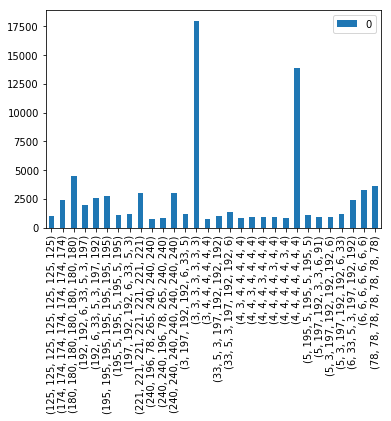

In [31]:
pd.DataFrame([dict(Counter(dict7_normal).most_common(30))]).T.plot.bar()

In [7]:
df_5  = pd.DataFrame(list(dict5_normal.items()))
df_5.shape

(43560, 2)

In [8]:
df_5.head()

,0,1
0,"(252, 252, 1, 1, 252)",7
1,"(252, 252, 252, 1, 1)",18
2,"(120, 175, 175, 54, 140)",3
3,"(175, 120, 175, 175, 54)",2
4,"(196, 38, 6, 6, 6)",11


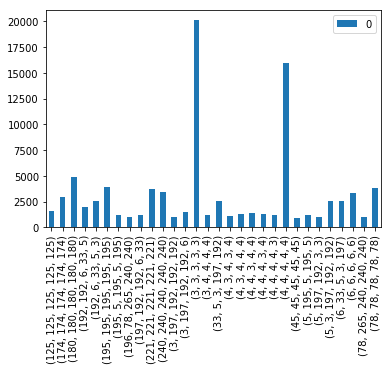

In [32]:
pd.DataFrame([dict(Counter(dict5_normal).most_common(30))]).T.plot.bar()

In [9]:
df_3  = pd.DataFrame(list(dict3_normal.items()))
df_3.shape

(10427, 2)

In [10]:
df_3.head()

,0,1
0,"(252, 1, 1)",41
1,"(252, 252, 1)",34
2,"(175, 175, 54)",9
3,"(120, 175, 175)",174
4,"(38, 6, 6)",24


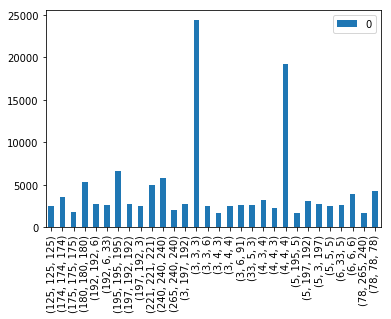

In [33]:
pd.DataFrame([dict(Counter(dict3_normal).most_common(30))]).T.plot.bar()

# Plots for top 30 3/5/7 grams distribution in Attack trace

In [11]:
df_7v  = pd.DataFrame(list(dict7.items()))
df_7v.shape

(226, 2)

In [12]:
df_7v.head()

,0,1
0,"(5, 5, 6, 3, 3, 197, 5)",1
1,"(5, 6, 3, 3, 197, 5, 5)",1
2,"(6, 3, 3, 197, 5, 5, 5)",1
3,"(3, 3, 197, 5, 5, 5, 6)",1
4,"(3, 197, 5, 5, 5, 6, 91)",1


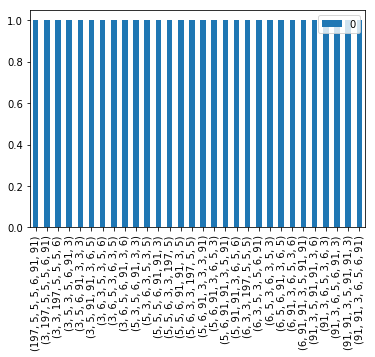

In [34]:
pd.DataFrame([dict(Counter(dict7).most_common(30))]).T.plot.bar()

In [13]:
df_5v  = pd.DataFrame(list(dict5.items()))
df_5v.head()

,0,1
0,"(141, 3, 91, 5, 197)",1
1,"(3, 141, 3, 91, 5)",1
2,"(5, 5, 6, 3, 3)",1
3,"(5, 6, 3, 3, 197)",1
4,"(6, 3, 3, 197, 5)",1


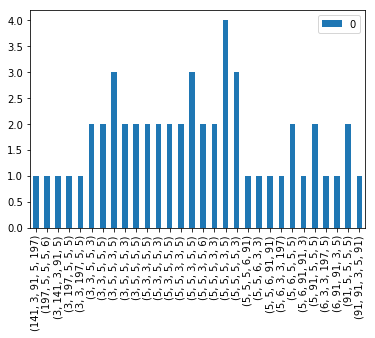

In [29]:
pd.DataFrame([dict(Counter(dict5).most_common(30))]).T.plot.bar()

In [16]:
df_3v  = pd.DataFrame(list(dict3.items()))
df_3v.head()

,0,1
0,"(3, 91, 5)",5
1,"(141, 3, 91)",2
2,"(3, 141, 3)",1
3,"(5, 5, 6)",5
4,"(5, 6, 3)",2


In [21]:
df_3v.shape

(86, 2)

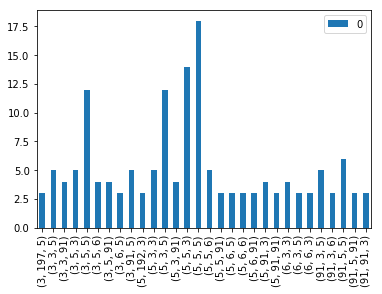

In [28]:
pd.DataFrame([dict(Counter(dict3).most_common(30))]).T.plot.bar()

# Find the frequency of occurences of all unique 3-grams, 5-grams and 7-grams system call sequences in the training data for both Attack data (across all categories of attack) and Normal data

In [15]:
print("\n\nCalculating the features(i.e. Top 30%) for all 3/5/7 Grams for all 6 Attacks and writing to files.")

# for the top 30% for each attack
Final7 = [Counter() for x in range(0,7)]
Final5 = [Counter() for x in range(0,7)]
Final3 = [Counter() for x in range(0,7)]

Features7 = set()
Features5 = set()
Features3 = set()

for i in range(0,6):            # 6 attack
	# first adding the results of different folders of each attack
	for j in range(0,7):            # 7 folders of each attack
		Final7[i] = Final7[i] + grams_7[i][j]
		Final5[i] = Final5[i] + grams_5[i][j]
		Final3[i] = Final3[i] + grams_3[i][j]
	Final7[i] = getFeatures(Final7[i], 'TRAINING/ATTACK-' + str(i+1) + '/top30%_7tupple.txt')
	Final5[i] = getFeatures(Final5[i], 'TRAINING/ATTACK-' + str(i+1) + '/top30%_5tupple.txt')
	Final3[i] = getFeatures(Final3[i], 'TRAINING/ATTACK-' + str(i+1) + '/top30%_3tupple.txt')

Features7 = set(Final7[0] + Final7[1] + Final7[2] + Final7[3] + Final7[4] + Final7[5] + Final7_normal)
Features5 = set(Final5[0] + Final5[1] + Final5[2] + Final5[3] + Final5[4] + Final5[5] + Final5_normal)
Features3 = set(Final3[0] + Final3[1] + Final3[2] + Final3[3] + Final3[4] + Final3[5] + Final3_normal)

print("Total 3 - Features = ", len(Features3))
print("Total 5 - Features = ", len(Features5))
print("Total 7 - Features = ", len(Features7))

displayTimeMessage()

# Generating validation data
validateGenerate()

displayTimeMessage()

FinalTime = datetime.now()

print("\n############################################################################################################################")
print("\nTOTAL TIME TAKEN BY THE SCRIPT : " + str((FinalTime-InitialTime).total_seconds()))



Calculating the features(i.e. Top 30%) for all 3/5/7 Grams for all 6 Attacks and writing to files.
Total 3 - Features =  6428
Total 5 - Features =  25350
Total 7 - Features =  45594

	Time Taken = 4.792213 seconds
############################################################################################################################

Finding the frequency of features in the Validation Dataset.

	Time Taken = 299.422719 seconds
############################################################################################################################

############################################################################################################################

TOTAL TIME TAKEN BY THE SCRIPT : 309.034472
